Epoch 1/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - AUC: 0.8416 - Precision: 0.7637 - Recall: 0.7637 - accuracy: 0.7637 - loss: 3.3108 - val_AUC: 0.8109 - val_Precision: 0.7248 - val_Recall: 0.7248 - val_accuracy: 0.7248 - val_loss: 2.6188 - learning_rate: 5.0000e-04
Epoch 2/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - AUC: 0.9836 - Precision: 0.9367 - Recall: 0.9367 - accuracy: 0.9367 - loss: 1.9980 - val_AUC: 0.8905 - val_Precision: 0.8050 - val_Recall: 0.8050 - val_accuracy: 0.8050 - val_loss: 1.9422 - learning_rate: 5.0000e-04
Epoch 3/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - AUC: 0.9851 - Precision: 0.9429 - Recall: 0.9429 - accuracy: 0.9429 - loss: 1.5208 - val_AUC: 0.8394 - val_Precision: 0.7546 - val_Recall: 0.7546 - val_accuracy: 0.7546 - val_loss: 1.9457 - learning_rate: 5.0000e-04
Epoch 4/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - AUC: 0.9877 - Precision: 0.9464 - Recall: 0.9464 - accuracy: 0.9464 - loss: 1.3057 - val_AUC: 0.8078 - val_Precision: 0.7179 - v

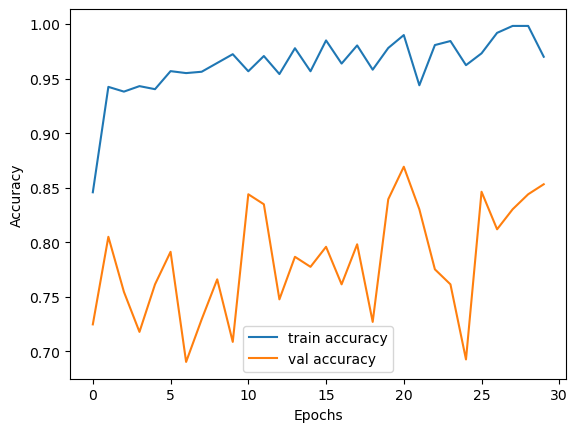

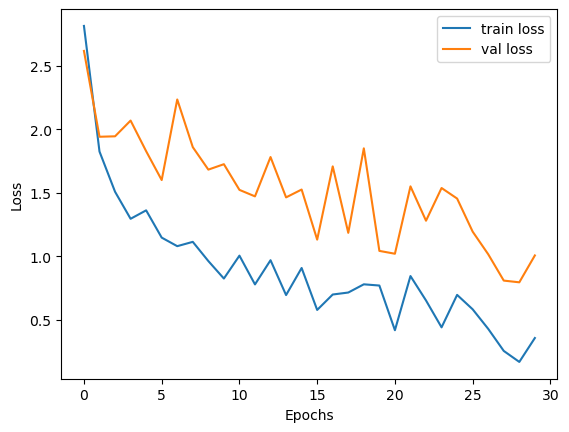

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


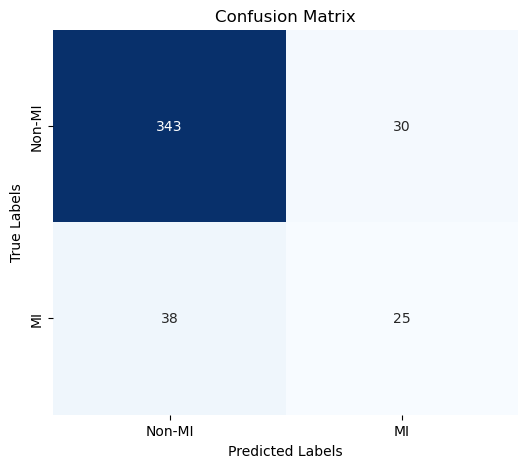

In [ ]:
import os
import pandas as pd
import numpy as np
import ast
import wfdb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Hyperparameters
learning_rate = 0.0005
dropout_rate = 0.5
l2_reg = 0.01
batch_size = 16
epochs = 30
filters = [32, 64]
kernel_size = 3
max_len = 1000
fs = 100

# Load Metadata
metadata_file = r"C:\Users\zain.hanif\Desktop\University\HIS Project\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\ptbxl_database.csv"
df = pd.read_csv(metadata_file)
base_path = r"C:\Users\zain.hanif\Desktop\University\HIS Project\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"

# Filter MI-related cases
mi_related_codes = ['MI', 'IMI', 'PMI', 'AMI', 'LMI']
df['is_mi_related'] = df['scp_codes'].apply(lambda x: any(code in ast.literal_eval(x) for code in mi_related_codes))

# Stratified Sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.9, random_state=42)
for train_index, _ in sss.split(df, df['is_mi_related']):
    df_sampled = df.iloc[train_index]

# Function to extract ECG data
def extract_data_and_labels(df_subset):
    ecg_data, labels = [], []
    for _, row in df_subset.iterrows():
        ecg_path_lr = os.path.join(base_path, row['filename_lr'])
        try:
            record = wfdb.rdrecord(ecg_path_lr.replace('.dat', ''), sampto=max_len)
            ecg_signal = record.p_signal
            if ecg_signal.ndim == 1:
                ecg_signal = ecg_signal.reshape(-1, 1)
            ecg_data.append(ecg_signal)
            labels.append(1 if row['is_mi_related'] else 0)
        except FileNotFoundError:
            print(f"Warning: File {ecg_path_lr} not found. Skipping.")
        except Exception as e:
            print(f"Error reading file {ecg_path_lr}: {e}")
            continue
    return np.array(ecg_data), np.array(labels)

X_train_original, y_train_original = extract_data_and_labels(df_sampled)

# Standardize signals
scaler = StandardScaler()
X_train_scaled = np.array([scaler.fit_transform(signal) for signal in X_train_original])

# Padding sequences
X_train_padded = sequence.pad_sequences(X_train_scaled, maxlen=max_len, dtype='float32', padding='post', truncating='post')
X_train = np.array([padded.reshape(max_len, X_train_padded.shape[-1]) for padded in X_train_padded])

# Handle class imbalance
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=np.unique(y_train_original), y=y_train_original)))

# Train-test split
X_train_split, X_test, y_train_split, y_test = train_test_split(X_train, y_train_original, test_size=0.2, random_state=42, stratify=y_train_original)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_flat = X_train_split.reshape(X_train_split.shape[0], -1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train_split)
X_train = X_train_resampled.reshape(-1, max_len, X_train.shape[2])

# One-hot encode labels
y_train = to_categorical(y_train_resampled, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Data Augmentation
def augment_data(signals):
    noise = 0.1 * np.random.normal(0, 1, signals.shape)
    scaled_signals = signals * (1 + 0.2 * np.random.uniform(-1, 1, signals.shape))
    return np.concatenate([signals, signals + noise, scaled_signals], axis=0)

X_train_augmented = augment_data(X_train)
y_train_augmented = np.tile(y_train, (3, 1))
X_train, y_train = X_train_augmented, y_train_augmented

# Model Architecture
input_shape = (max_len, X_train.shape[2])

model = Sequential([
    Input(shape=input_shape),
    
    Conv1D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    LSTM(64, return_sequences=False), 
    
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss')

# Train Model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    class_weight=class_weights,
                    callbacks=[lr_scheduler, early_stopping, model_checkpoint])

# Evaluate Model
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, AUC: {test_auc:.4f}")

# Plot Metrics
def plot_metric(history, metric):
    plt.plot(history.history[metric], label=f'train {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'val {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

plot_metric(history, 'accuracy')
plot_metric(history, 'loss')


# 🔹 Load the best saved model
best_model = tf.keras.models.load_model("best_model.keras")

# 🔹 Make predictions on the test set
y_pred = best_model.predict(X_test)

# 🔹 Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 🔹 Generate the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# 🔹 Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Non-MI', 'MI'], yticklabels=['Non-MI', 'MI'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



Epoch 1/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 48s 56ms/step - AUC: 0.8332 - Precision: 0.7697 - Recall: 0.7697 - accuracy: 0.7697 - loss: 3.9822 - val_AUC: 0.5009 - val_Precision: 0.5092 - val_Recall: 0.5092 - val_accuracy: 0.5092 - val_loss: 5.0905 - learning_rate: 5.0000e-04
Epoch 2/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - AUC: 0.9637 - Precision: 0.8987 - Recall: 0.8987 - accuracy: 0.8987 - loss: 1.7611 - val_AUC: 0.4853 - val_Precision: 0.5126 - val_Recall: 0.5126 - val_accuracy: 0.5126 - val_loss: 4.5501 - learning_rate: 5.0000e-04
Epoch 3/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - AUC: 0.9723 - Precision: 0.9170 - Recall: 0.9170 - accuracy: 0.9170 - loss: 1.2091 - val_AUC: 0.6808 - val_Precision: 0.6399 - val_Recall: 0.6399 - val_accuracy: 0.6399 - val_loss: 2.1483 - learning_rate: 5.0000e-04
Epoch 4/50
747/747 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - AUC: 0.9782 - Precision: 0.9280 - Recall: 0.9280 - accuracy: 0.9280 - loss: 1.0454 - val_AUC: 0.7356 - val_Precision: 0.7007 - v

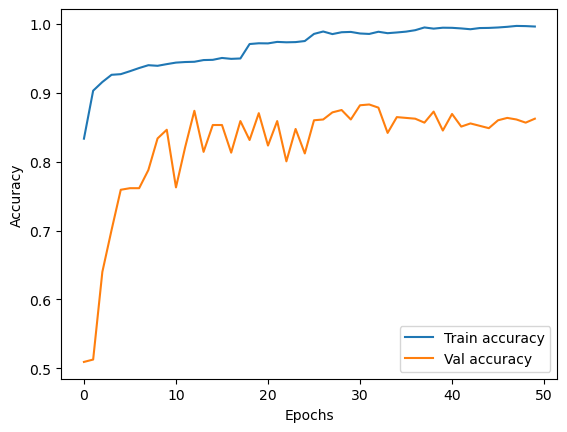

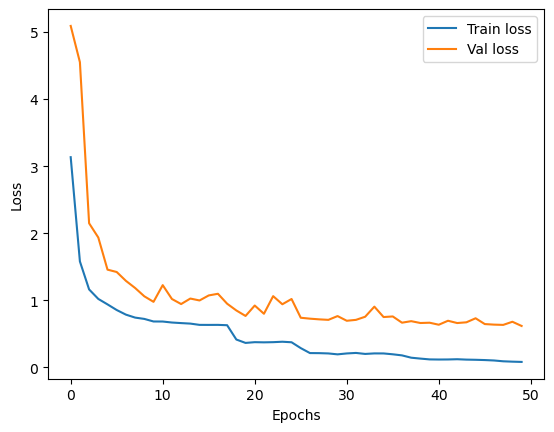

In [ ]:
import os
import pandas as pd
import numpy as np
import ast
import wfdb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# 🔹 Hyperparameters
learning_rate = 0.0005
dropout_rate = 0.5
l2_reg = 0.01
batch_size = 32
epochs = 50
filters = [32, 64, 128]
kernel_size = 3
max_len = 1000
fs = 100

# 🔹 Load Metadata
metadata_file = r"C:\Users\zain.hanif\Desktop\University\HIS Project\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3\ptbxl_database.csv"
df = pd.read_csv(metadata_file)
base_path = r"C:\Users\zain.hanif\Desktop\University\HIS Project\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"

# 🔹 Filter MI-related cases
mi_related_codes = ['MI', 'IMI', 'PMI', 'AMI', 'LMI']
df['is_mi_related'] = df['scp_codes'].apply(lambda x: any(code in ast.literal_eval(x) for code in mi_related_codes))

# 🔹 Stratified Sampling (Reducing Data for Faster Training)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.8, random_state=42)
for train_index, _ in sss.split(df, df['is_mi_related']):
    df_sampled = df.iloc[train_index]

# 🔹 Function to Extract ECG Data
def extract_data_and_labels(df_subset):
    ecg_data, labels = [], []
    for _, row in df_subset.iterrows():
        ecg_path_lr = os.path.join(base_path, row['filename_lr'])
        try:
            record = wfdb.rdrecord(ecg_path_lr.replace('.dat', ''), sampto=max_len)
            ecg_signal = record.p_signal
            if ecg_signal.ndim == 1:
                ecg_signal = ecg_signal.reshape(-1, 1)
            ecg_data.append(ecg_signal)
            labels.append(1 if row['is_mi_related'] else 0)
        except FileNotFoundError:
            print(f"Warning: File {ecg_path_lr} not found. Skipping.")
        except Exception as e:
            print(f"Error reading file {ecg_path_lr}: {e}")
            continue
    return np.array(ecg_data), np.array(labels)

X_train_original, y_train_original = extract_data_and_labels(df_sampled)

# 🔹 Standardize Signals
scaler = StandardScaler()
X_train_scaled = np.array([scaler.fit_transform(signal) for signal in X_train_original])

# 🔹 Padding Sequences
X_train_padded = sequence.pad_sequences(X_train_scaled, maxlen=max_len, dtype='float32', padding='post', truncating='post')
X_train = np.array([padded.reshape(max_len, X_train_padded.shape[-1]) for padded in X_train_padded])

# 🔹 Train-Test Split
X_train_split, X_test, y_train_split, y_test = train_test_split(X_train, y_train_original, test_size=0.2, random_state=42, stratify=y_train_original)

# 🔹 Apply SMOTE to Handle Class Imbalance
smote = SMOTE(random_state=42)
X_train_flat = X_train_split.reshape(X_train_split.shape[0], -1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train_split)
X_train = X_train_resampled.reshape(-1, max_len, X_train.shape[2])

# 🔹 One-Hot Encode Labels
y_train = to_categorical(y_train_resampled, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# 🔹 Data Augmentation Function
def augment_data(signals):
    noise = 0.05 * np.random.normal(0, 1, signals.shape)
    scaled_signals = signals * (1 + 0.1 * np.random.uniform(-1, 1, signals.shape))
    shifted_signals = np.roll(signals, shift=np.random.randint(5, 20), axis=1)
    return np.concatenate([signals, signals + noise, scaled_signals, shifted_signals], axis=0)

X_train_augmented = augment_data(X_train)
y_train_augmented = np.tile(y_train, (4, 1))
X_train, y_train = X_train_augmented, y_train_augmented

# 🔹 Model Architecture
input_shape = (max_len, X_train.shape[2])

model = Sequential([
    Input(shape=input_shape),

    Conv1D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(l2_reg)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),

    LSTM(64, return_sequences=False), 

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(l2_reg)),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# 🔹 Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)

# 🔹 Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss')

# 🔹 Train Model
history = model.fit(
    X_train, y_train, 
    epochs=epochs, batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler, early_stopping, model_checkpoint]
)

# 🔹 Evaluate Model
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(X_test, y_test, verbose=1)
print(f"✅ Test Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, AUC: {test_auc:.4f}")

# 🔹 Plot Training Metrics
def plot_metric(history, metric):
    plt.plot(history.history[metric], label=f'Train {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

plot_metric(history, 'accuracy')
plot_metric(history, 'loss')


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


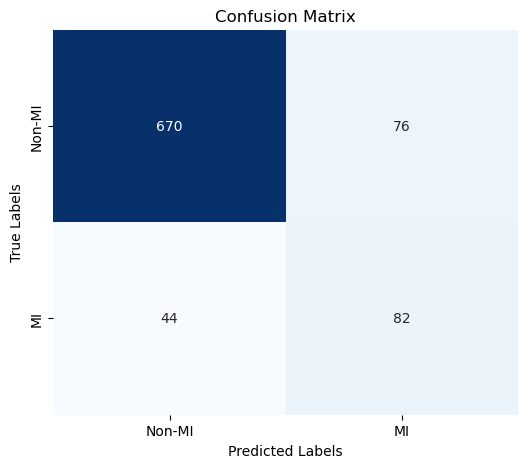

Accuracy: 0.8624
Precision: 0.5190
Recall: 0.6508
F1-Score: 0.5775
Specificity: 0.8981


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 🔹 Load the best saved model
best_model = tf.keras.models.load_model("best_model.keras")

# 🔹 Make predictions on the test set
y_pred = best_model.predict(X_test)

# 🔹 Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 🔹 Generate the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# 🔹 Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Non-MI', 'MI'], yticklabels=['Non-MI', 'MI'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


